<a href="https://colab.research.google.com/github/nex-ro/prediciton-rupiah-to-usd-/blob/main/project_dl_uas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [165]:
data=pd.read_csv('Data Historis USD_IDR.csv')
data = data[::-1]

# Preprocessing


In [166]:
data.drop(['Pembukaan','Tertinggi','Terendah','Vol.','Perubahan%'],axis=1,inplace=True)

In [167]:
data

,Tanggal,Terakhir
1258,26/06/2020,"14.220,0"
1257,29/06/2020,"14.245,0"
1256,30/06/2020,"14.255,0"
1255,01/07/2020,"14.265,0"
1254,02/07/2020,"14.378,5"
...,...,...
4,22/06/2025,"16.373,5"
3,23/06/2025,"16.485,0"
2,24/06/2025,"16.350,0"
1,25/06/2025,"16.290,0"


In [168]:
data.isnull().sum()

,0
Tanggal,0
Terakhir,0


In [169]:
data=data['Terakhir']

In [170]:
data = data.str.replace('.', '', regex=False)
data = data.str.replace(',', '.', regex=False)
data = data.astype(float)

In [171]:
data

,Terakhir
1258,14220.0
1257,14245.0
1256,14255.0
1255,14265.0
1254,14378.5
...,...
4,16373.5
3,16485.0
2,16350.0
1,16290.0


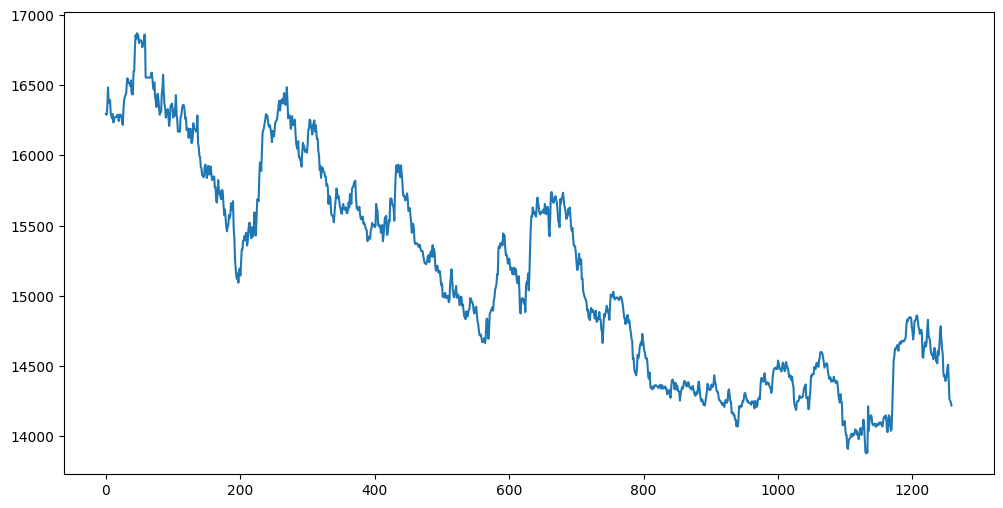

ADF Statistic: -1.048924
p-value: 0.735005
Critical Values:
   1%: -3.4355880246374304
   5%: -2.8638531175675896
   10%: -2.568001531098063


In [204]:
from statsmodels.tsa.stattools import adfuller

from matplotlib import pyplot
pyplot.figure(figsize=(12,6))
pyplot.plot(data)
pyplot.show()
adf_result = adfuller(data)
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')


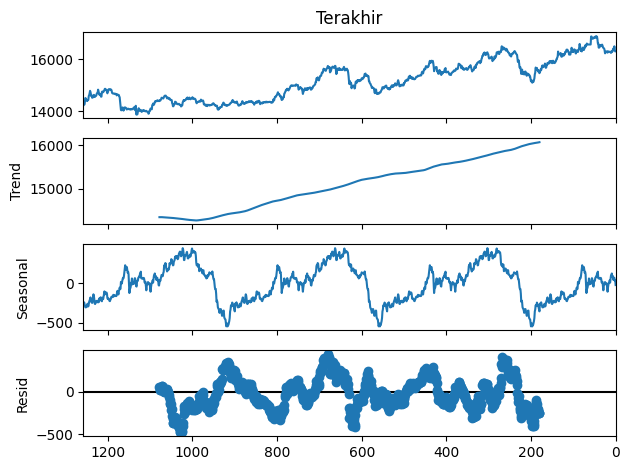

In [202]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data, model='additive', period=360)

result.plot()
plt.tight_layout()
plt.show()


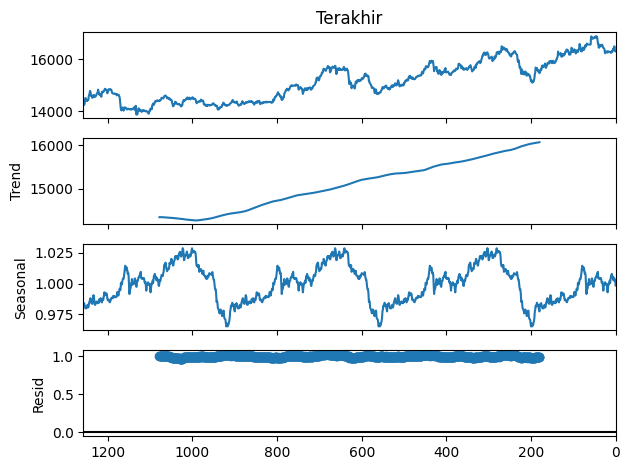

In [203]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data, model='multiplicative', period=360)

result.plot()
plt.tight_layout()
plt.show()


In [109]:
scaler=MinMaxScaler()
data=scaler.fit_transform(np.array(data).reshape(-1,1))

In [110]:
def create_sequences(data,seq_length):
  x,y=[],[]
  for i in range(len(data)-seq_length):
    a=data[i:(i+seq_length)]
    x.append(a)
    y.append(data[i+seq_length])
  return np.array(x),np.array(y)

In [111]:
seq=30
x,y=create_sequences(data,seq)

In [112]:
x

array([[[0.11371237],
        [0.12207358],
        [0.12541806],
        ...,
        [0.22408027],
        [0.23578595],
        [0.23411371]],

       [[0.12207358],
        [0.12541806],
        [0.12876254],
        ...,
        [0.23578595],
        [0.23411371],
        [0.23745819]],

       [[0.12541806],
        [0.12876254],
        [0.16672241],
        ...,
        [0.23411371],
        [0.23745819],
        [0.24749164]],

       ...,

       [[0.89297659],
        [0.8812709 ],
        [0.85618729],
        ...,
        [0.83779264],
        [0.83394649],
        [0.87123746]],

       [[0.8812709 ],
        [0.85618729],
        [0.85284281],
        ...,
        [0.83394649],
        [0.87123746],
        [0.82608696]],

       [[0.85618729],
        [0.85284281],
        [0.84782609],
        ...,
        [0.87123746],
        [0.82608696],
        [0.80602007]]])

In [113]:
y

array([[0.23745819],
       [0.24749164],
       [0.26923077],
       ...,
       [0.82608696],
       [0.80602007],
       [0.8077592 ]])

In [114]:
x=x.reshape(x.shape[0],x.shape[1],1)

In [115]:
y.shape

(1229, 1)

In [116]:
x.shape

(1229, 30, 1)

In [117]:
split_index = int(len(x) * 0.8)

x_train = x[:split_index]
y_train = y[:split_index]

x_test = x[split_index:]
y_test = y[split_index:]


# **LSTM**

In [118]:
pip install tensorflow


In [119]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.layers import Dropout


In [120]:
model = Sequential()
model.add(LSTM(64, input_shape=(seq, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [121]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(x_train, y_train, validation_split=0.2,epochs=100, batch_size=32, callbacks=[early_stop])


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0435 - val_loss: 0.0362
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0057 - val_loss: 0.0043
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

In [128]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(x_test)
print("MSE :", mean_squared_error(y_test, y_pred))
print("MAE :", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))
from math import sqrt
print("RMSE:", sqrt(mean_squared_error(y_test, y_pred)))


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
MSE : 0.0016302087946336707
MAE : 0.029533076276364815
R2 Score: 0.9207843151470669
RMSE: 0.04037584419716411


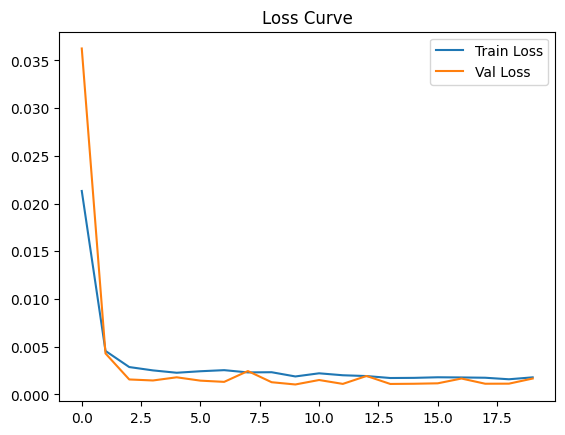

In [123]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()

In [124]:
predictions=model.predict(x)
predictions=scaler.inverse_transform(predictions)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


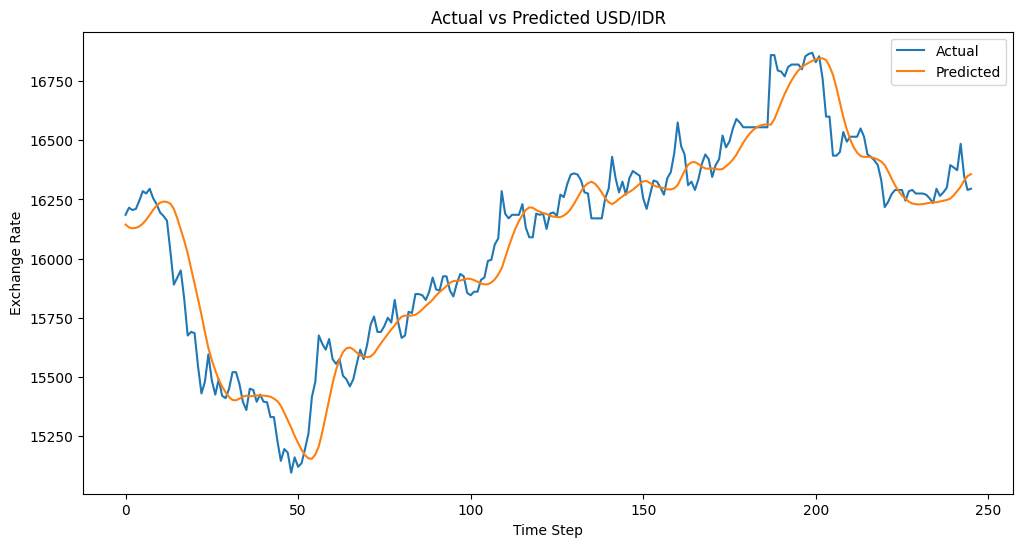

In [125]:
# Denormalisasi hasil prediksi dan label asli
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.legend()
plt.title("Actual vs Predicted USD/IDR")
plt.xlabel("Time Step")
plt.ylabel("Exchange Rate")
plt.show()


In [126]:
last_seq = x[-1]
last_seq = last_seq.reshape(1, seq, 1)
next_pred = model.predict(last_seq)
next_pred = scaler.inverse_transform(next_pred)
print("Prediksi Hari Berikutnya:", next_pred[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediksi Hari Berikutnya: 16356.899


# ARIMA

In [131]:
pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 17.9 MB/s eta 0:00:00


In [178]:
train_size = int(len(data) * 0.8)
train = data.iloc[:train_size]  # Series
test = data.iloc[train_size:]

In [132]:
import itertools
from statsmodels.tsa.arima.model import ARIMA

In [188]:
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))

best_rmse = float("inf")
best_order = None
rmse_results = []

for order in pdq:
    try:
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        rmse = sqrt(mean_squared_error(test, forecast))
        rmse_results.append((order, rmse))

        if rmse < best_rmse:
            best_rmse = rmse
            best_order = order

        print(f"ARIMA{order} - RMSE: {rmse:.4f}")
    except:
        continue

print(f"\n✅ Best ARIMA order (by RMSE): {best_order}")



ARIMA(0, 0, 0) - RMSE: 1249.9242
ARIMA(0, 0, 1) - RMSE: 1247.4269
ARIMA(0, 0, 2) - RMSE: 1246.4233
ARIMA(0, 0, 3) - RMSE: 1242.6333
ARIMA(0, 1, 0) - RMSE: 447.5693
ARIMA(0, 1, 1) - RMSE: 447.2594
ARIMA(0, 1, 2) - RMSE: 447.2471
ARIMA(0, 1, 3) - RMSE: 447.9911
ARIMA(0, 2, 0) - RMSE: 1552.2741
ARIMA(0, 2, 1) - RMSE: 527.2946
ARIMA(0, 2, 2) - RMSE: 521.2647
ARIMA(0, 2, 3) - RMSE: 521.3081
ARIMA(0, 3, 0) - RMSE: 73212.8398
ARIMA(0, 3, 1) - RMSE: 2787.6707
ARIMA(0, 3, 2) - RMSE: 759.6322
ARIMA(0, 3, 3) - RMSE: 732.2463
ARIMA(1, 0, 0) - RMSE: 541.2683
ARIMA(1, 0, 1) - RMSE: 547.2600
ARIMA(1, 0, 2) - RMSE: 516.9240
ARIMA(1, 0, 3) - RMSE: 499.1975
ARIMA(1, 1, 0) - RMSE: 447.2184
ARIMA(1, 1, 1) - RMSE: 447.2546
ARIMA(1, 1, 2) - RMSE: 447.1843
ARIMA(1, 1, 3) - RMSE: 447.6584
ARIMA(1, 2, 0) - RMSE: 1340.0258
ARIMA(1, 2, 1) - RMSE: 521.3238
ARIMA(1, 2, 2) - RMSE: 522.9411
ARIMA(1, 2, 3) - RMSE: 522.7182
ARIMA(1, 3, 0) - RMSE: 67062.5320
ARIMA(1, 3, 1) - RMSE: 2197.1143


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 3, 2) - RMSE: 669.0246
ARIMA(1, 3, 3) - RMSE: 742.4068
ARIMA(2, 0, 0) - RMSE: 552.2201
ARIMA(2, 0, 1) - RMSE: 570.7067
ARIMA(2, 0, 2) - RMSE: 584.0589
ARIMA(2, 0, 3) - RMSE: 554.8621
ARIMA(2, 1, 0) - RMSE: 447.3111
ARIMA(2, 1, 1) - RMSE: 447.7888
ARIMA(2, 1, 2) - RMSE: 447.6688
ARIMA(2, 1, 3) - RMSE: 447.6695
ARIMA(2, 2, 0) - RMSE: 1661.8098
ARIMA(2, 2, 1) - RMSE: 521.3391
ARIMA(2, 2, 2) - RMSE: 525.2621


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 3) - RMSE: 522.5318
ARIMA(2, 3, 0) - RMSE: 147585.5664
ARIMA(2, 3, 1) - RMSE: 2390.0852


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 3, 2) - RMSE: 697.5781
ARIMA(2, 3, 3) - RMSE: 720.0368
ARIMA(3, 0, 0) - RMSE: 542.5135
ARIMA(3, 0, 1) - RMSE: 585.4929
ARIMA(3, 0, 2) - RMSE: 564.2825
ARIMA(3, 0, 3) - RMSE: 483.5861
ARIMA(3, 1, 0) - RMSE: 447.9619
ARIMA(3, 1, 1) - RMSE: 447.7198
ARIMA(3, 1, 2) - RMSE: 447.6690


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3) - RMSE: 445.7874
ARIMA(3, 2, 0) - RMSE: 2445.1089
ARIMA(3, 2, 1) - RMSE: 529.5111
ARIMA(3, 2, 2) - RMSE: 523.0390
ARIMA(3, 2, 3) - RMSE: 524.2211
ARIMA(3, 3, 0) - RMSE: 143017.0361
ARIMA(3, 3, 1) - RMSE: 3317.2524
ARIMA(3, 3, 2) - RMSE: 760.1594
ARIMA(3, 3, 3) - RMSE: 476.6025

✅ Best ARIMA order (by RMSE): (3, 1, 3)


In [193]:
from sklearn.metrics import mean_absolute_error, r2_score

forecast = best_model.forecast(steps=len(test))

mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = sqrt(mse)
r2 = r2_score(test, forecast)
mape = np.mean(np.abs((test - forecast) / test)) * 100

print(f"\n✅ Best ARIMA order (by RMSE): {best_order}")
print(f"MAE  : {mae:.3f}")
print(f"MSE  : {mse:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")
print(f"MAPE : {mape:.2f}%")



✅ Best ARIMA order (by RMSE): (3, 1, 3)
MAE  : 337.206
MSE  : 198726.386
RMSE : 445.787
R²   : -0.106
MAPE : 2.13%


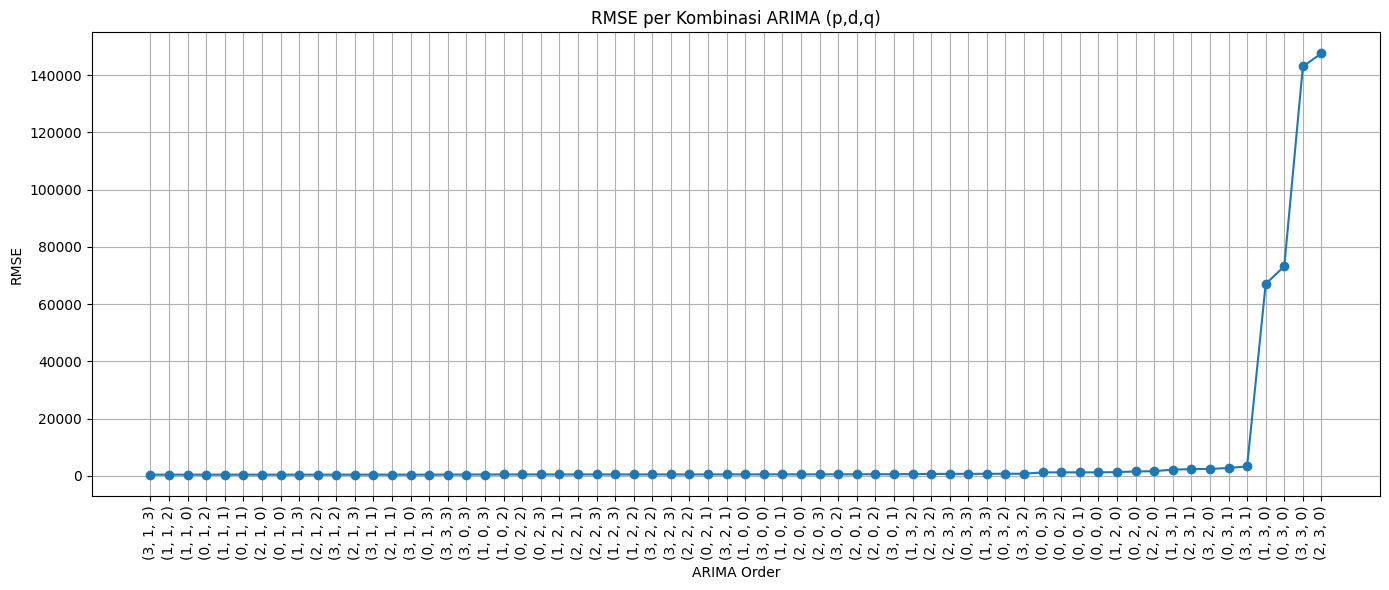

In [194]:
import matplotlib.pyplot as plt

rmse_results.sort(key=lambda x: x[1])

orders = [str(x[0]) for x in rmse_results]
rmses = [x[1] for x in rmse_results]

plt.figure(figsize=(14,6))
plt.plot(orders, rmses, marker='o')
plt.xticks(rotation=90)
plt.title("RMSE per Kombinasi ARIMA (p,d,q)")
plt.xlabel("ARIMA Order")
plt.ylabel("RMSE")
plt.grid(True)
plt.tight_layout()
plt.show()

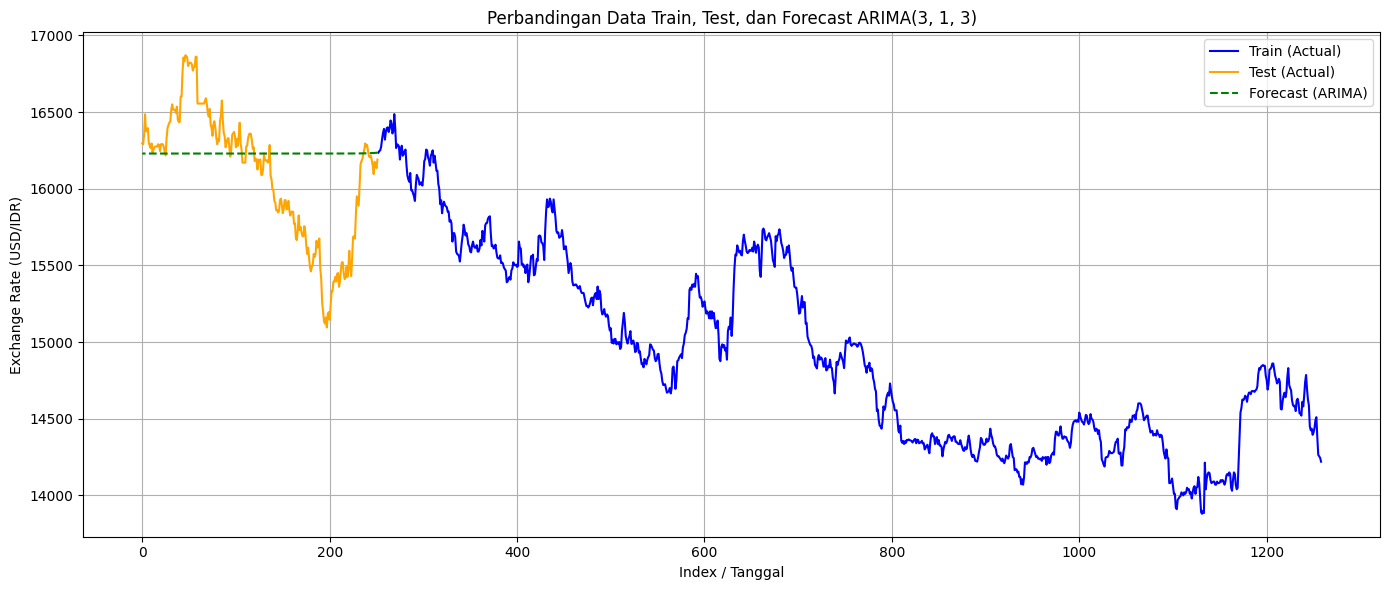

In [195]:
plt.figure(figsize=(14,6))

# Gabungkan x-axis untuk semua data
full_index = list(train.index) + list(test.index)

# Gabungkan nilai aktual
full_data = pd.concat([train, test])

# Plot data train
plt.plot(train.index, train, label='Train (Actual)', color='blue')

# Plot data test
plt.plot(test.index, test, label='Test (Actual)', color='orange')

# Plot hasil prediksi ARIMA hanya untuk test set
plt.plot(test.index, forecast, label='Forecast (ARIMA)', color='green', linestyle='dashed')

plt.title(f'Perbandingan Data Train, Test, dan Forecast ARIMA{best_order}')
plt.xlabel('Index / Tanggal')
plt.ylabel('Exchange Rate (USD/IDR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
